In [63]:
from stellargraph.data import EdgeSplitter
import stellargraph as sg
import numpy as np
from sklearn.model_selection import train_test_split
import multiprocessing
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score
import networkx as nx
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA

## Constansok

In [64]:
# ['0', '107']
edge_path = 'facebook/0.edges' # 0.edges

In [65]:
def create_mapping(path):
    with open(path, 'rt') as file:
        text = file.read()

    # Feldolgozom a sorokat
    connections = []
    from_list = []
    to_list = []
    for row in text.split('\n')[:-1]:
        a, b = [int(x) for x in row.split(' ')]
        connections.append((a, b))

        from_list.append(a)
        to_list.append(b)


    id_mapper = {}
    reverse_id_mapper = {}
    counter = 0
    for elem in from_list:
        if elem not in id_mapper.values():
            id_mapper[counter] = elem
            reverse_id_mapper[elem] = counter
            counter += 1

    for elem in to_list:
        if elem not in id_mapper.values():
            id_mapper[counter] = elem
            reverse_id_mapper[elem] = counter
            counter += 1

    scaled_connections = []
    for first, second in connections:
        first_scaled = reverse_id_mapper[first]
        second_scaled = reverse_id_mapper[second]

        scaled_connections.append((first_scaled, second_scaled))

    return id_mapper, reverse_id_mapper, scaled_connections

def read_graph(path, map = True):
    id_mapper = None
    reverse_id_mapper = None

    if map:
        id_mapper, reverse_id_mapper, edges = create_mapping(path)
        G = nx.Graph()
        G.add_edges_from(edges)
    else:
        G = nx.read_edgelist(path, nodetype=int, create_using=nx.Graph())

    G = sg.StellarGraph.from_networkx(G)

    return G, id_mapper, reverse_id_mapper

In [66]:
G, id_mapper, reverse_id_mapper = read_graph(edge_path, map =True)
print(G.info())


# for edge in G.edges():
#     G[edge[0]][edge[1]]['weight'] = 1

StellarGraph: Undirected multigraph
 Nodes: 333, Edges: 2519

 Node types:
  default: [333]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2519]
        Weights: all 1 (default)
        Features: none


## Start

In [67]:
edge_splitter_test = EdgeSplitter(G)

In [68]:
# Itt az edge_splitter tesztből vesz éleket, ezeket az examples_test,
# Majd vesz negatív éleket is, ezt szintén hozzárakja az examples_test-hez concatolva,
# a labels test az, hogy ez az él létezik-e vagy sem
# a graph test a gráf a maradék éllel
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(p=0.1, method="global")

** Sampled 251 positive and 251 negative edges. **


In [69]:
def print_graph_info(graph):
    print(graph.info())

In [70]:
print_graph_info(graph_test)

StellarGraph: Undirected multigraph
 Nodes: 333, Edges: 2268

 Node types:
  default: [333]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2268]
        Weights: all 1 (default)
        Features: none


In [71]:
edge_splitter_train = EdgeSplitter(g=graph_test, g_master=G)
graph_train, examples, labels = edge_splitter_train.train_test_split(p=0.1, method="global")



(examples_train, examples_model_selection, labels_train, labels_model_selection,)\
                                        = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

** Sampled 226 positive and 226 negative edges. **


In [72]:
print_graph_info(graph_train)

StellarGraph: Undirected multigraph
 Nodes: 333, Edges: 2042

 Node types:
  default: [333]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2042]
        Weights: all 1 (default)
        Features: none


In [73]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,339,Train Graph,Test Graph,Train the Link Classifier
Model Selection,113,Train Graph,Test Graph,Select the best Link Classifier model
Test set,502,Test Graph,Full Graph,Evaluate the best Link Classifier


In [74]:
used_params = {
    'p': 1.0,
    'q': 0.8,
    'dimensions': 32,
    'num_walks': 100,
    'walk_length': 30,
    'window_size': 13,
    'num_iter': 50
}

In [75]:
# p = 1.0
# q = 1.0
# dimensions = 128
# num_walks = 60
# walk_length = 60
# window_size = 16
# num_iter = 5
workers = multiprocessing.cpu_count()

In [76]:
def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=used_params['num_walks'], length=used_params['walk_length'], p=used_params['p'], q=used_params['q'])
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        vector_size=used_params['dimensions'],
        window=used_params['window_size'],
        min_count=0,
        sg=1,
        workers=workers,
        epochs=used_params['num_iter'],
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [77]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 33300


In [78]:
# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]

# 2. training classifier
def train_link_prediction_model(
        link_examples, link_labels, get_embedding, binary_operator
):
    # Ezt akár lehet módosítani is más algoritmussal
    clf = link_prediction_classifier()

    # Itt távolságot számol a start és end pont embeddingje között
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    # Majd arra fitteli a modelt
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=4000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
        clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

In [79]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }

binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [80]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_l2'


,ROC AUC score
name,
operator_hadamard,0.845397
operator_l1,0.898095
operator_l2,0.903492
operator_avg,0.649524


In [81]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 33300


In [82]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_l2': 0.9412549007158616


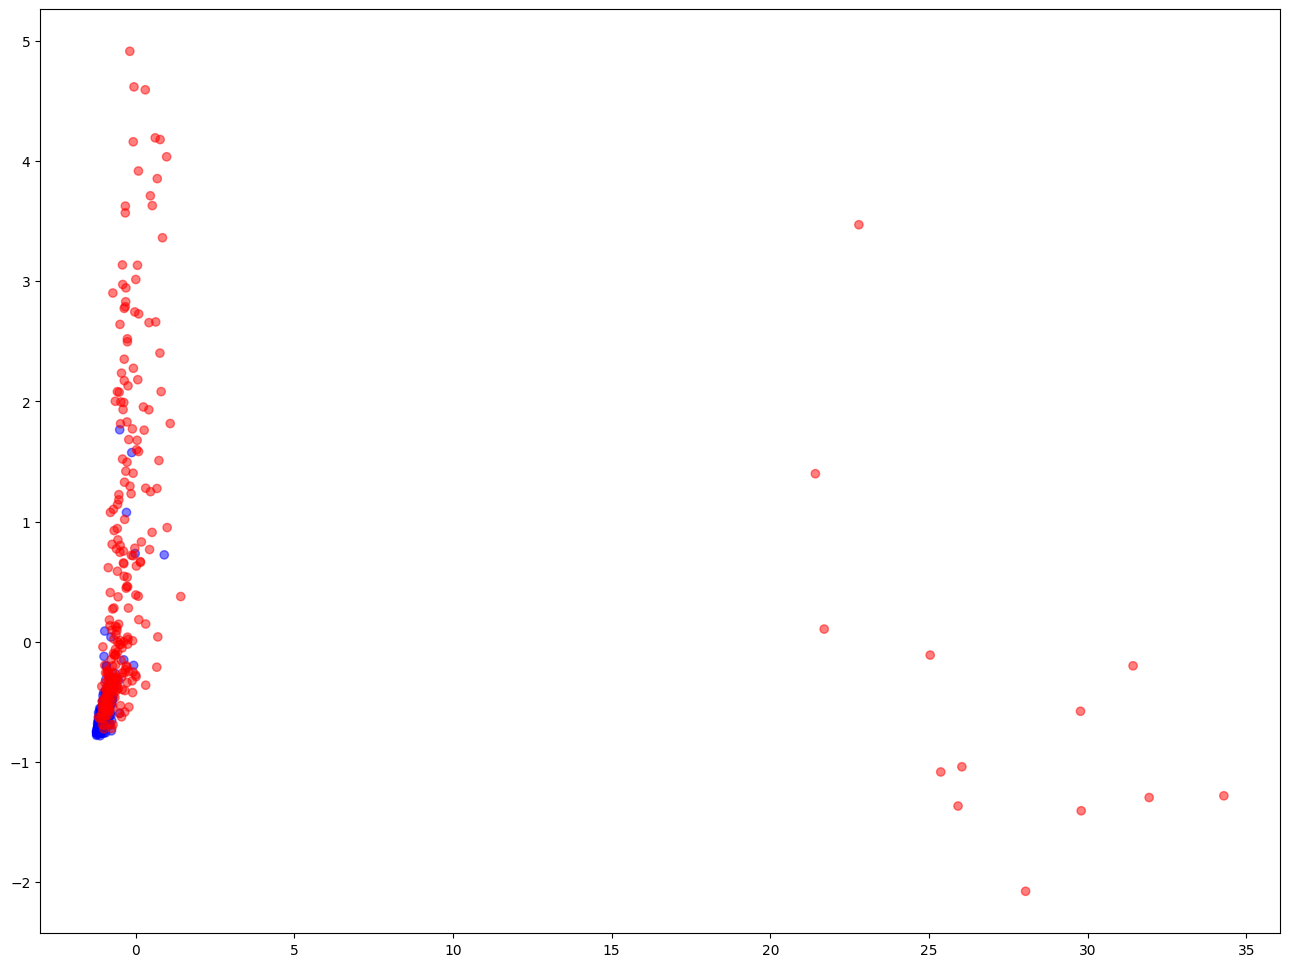

In [83]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)

## Inference

In [84]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 333, Edges: 2519

 Node types:
  default: [333]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2519]
        Weights: all 1 (default)
        Features: none


In [85]:
embedding_all = node2vec_embedding(G, "Test Graph")

Number of random walks for 'Test Graph': 33300


In [86]:
final_model = best_result['classifier']
final_operator = best_result['binary_operator']

nodes = list(G.nodes())
nodes.sort()

In [87]:
A = {}
for node1 in nodes:
    for node2 in nodes:
        if node1 < node2:
            first_embedding = embedding_all(node1)
            second_embedding = embedding_all(node2)

            distance_vector = final_operator(first_embedding, second_embedding)

            prob = final_model.predict_proba([distance_vector])

            A[(node1, node2)] = prob[0][0]

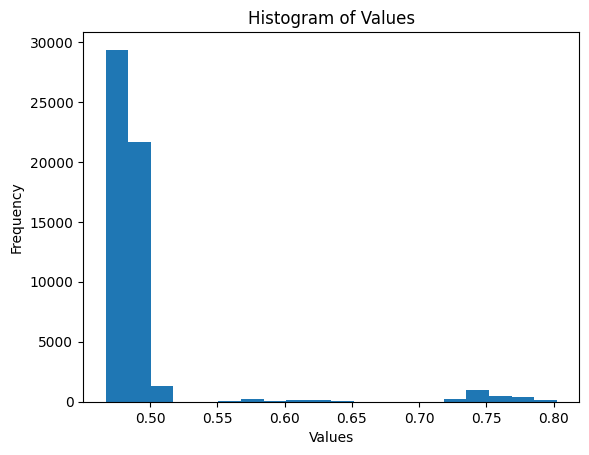

In [88]:
# Create a histogram
plt.hist(list(A.values()), bins=20)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()

In [89]:
len(A.values())

55278

In [90]:
# G.edges()

In [91]:
prob_df = pd.DataFrame(list(A.keys()), columns=['first_node', 'second_node'])
prob_df['prob'] = A.values()

prob_df = prob_df.set_index(['first_node', 'second_node'])

In [92]:
graph_edges = [(min(u, v), max(u, v)) for u, v in G.edges()]
graph_df = pd.DataFrame(graph_edges, columns=['first_node', 'second_node'])

graph_df = graph_df.set_index(['first_node', 'second_node'])

In [93]:
graph_df['edge'] = 1

In [94]:
result_df = prob_df.join(graph_df, how = 'left')
result_df['edge'] = result_df['edge'].fillna(0)
result_df['pred_edge'] = result_df['prob'].apply(lambda x: 1 if x > 0.5 else 0)

In [95]:
result_df.head()

prob  edge  pred_edge
first_node second_node                           
0          1            0.470447   1.0          0
           2            0.478837   0.0          0
           3            0.469328   1.0          0
           4            0.473468   0.0          0
           5            0.475216   0.0          0

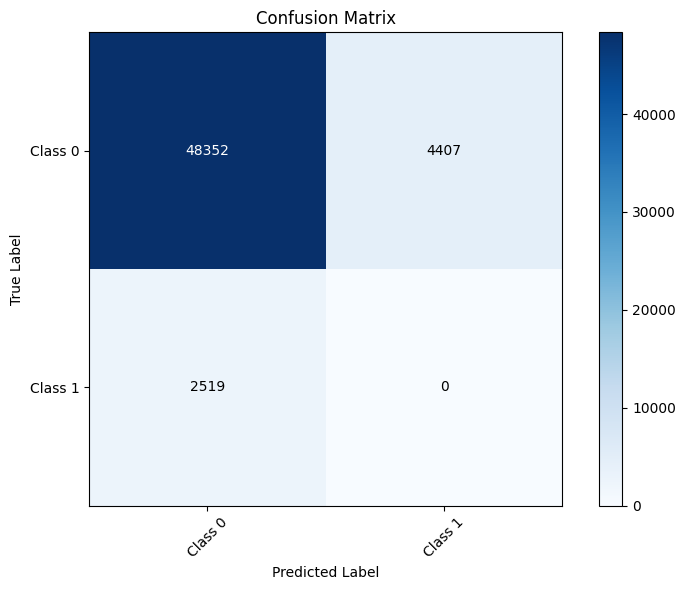

In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you already have the confusion matrix 'cm'


def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    plt.show()


cm = confusion_matrix(result_df['edge'], result_df['pred_edge'])

# Define class labels (if applicable)
class_labels = ['Class 0', 'Class 1']

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=class_labels)

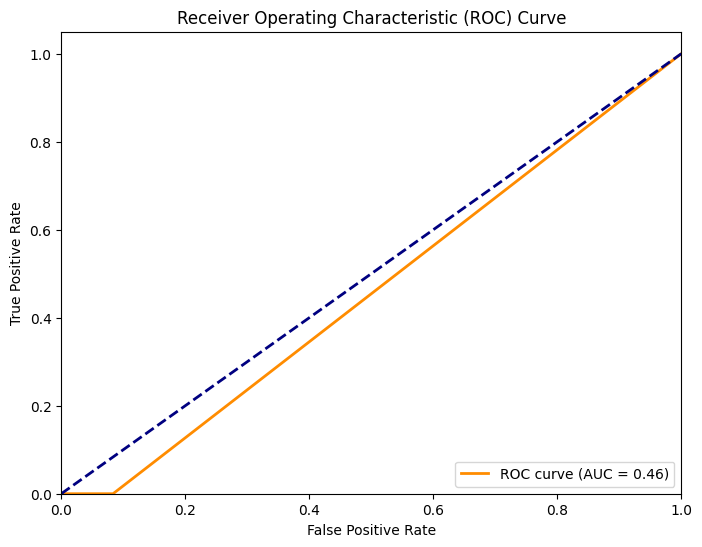

In [97]:
def plot_roc_curve(predictions_df):
    # Extract the 'Real', 'Pred', and 'Prob' columns
    ground_truth_values = predictions_df['edge'].tolist()
    predictions = predictions_df['pred_edge'].tolist()

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(ground_truth_values, predictions)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = roc_auc_score(ground_truth_values, predictions)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage:
plot_roc_curve(result_df)

In [98]:
result_df

prob  edge  pred_edge
first_node second_node                           
0          1            0.470447   1.0          0
           2            0.478837   0.0          0
           3            0.469328   1.0          0
           4            0.473468   0.0          0
           5            0.475216   0.0          0
...                          ...   ...        ...
329        331          0.498675   0.0          0
           332          0.495761   0.0          0
330        331          0.794337   0.0          1
           332          0.775974   0.0          1
331        332          0.499574   0.0          0

[55278 rows x 3 columns]

In [ ]:
result_df.groupby('edge').mean()

In [99]:
user = 2 #322

possible_connections = []

for node in G.nodes():
    if node != user:
        possible_connections.append((user, node))

In [100]:
len(possible_connections)

332

In [101]:
existing_connections = {}
for (start, end ) in possible_connections:
    if (start, end) in G.edges() or (end, start) in G.edges():
        existing_connections[(start, end)] = 1
    else:
        existing_connections[(start, end)] = 0

In [102]:
best_binary_operator = best_result['binary_operator']
model = best_result['classifier']

full_graph = node2vec_embedding(G, "Full graph embedding")

emb_distance = [best_binary_operator(embedding_train(src), embedding_train(dst)) for src, dst in possible_connections]

Number of random walks for 'Full graph embedding': 33300


In [103]:
preds = model.predict(emb_distance)
pred_prob = model.predict_proba(emb_distance)

In [104]:
# Create a DataFrame from the existing_connections dictionary
df = pd.DataFrame(list(existing_connections.items()), columns=['Connection', 'Real'])
df['Pred'] = preds
df['Prob'] = pred_prob[:, 1]

In [105]:
def calculate_accuracy(real, pred):
    accuracy = accuracy_score(real, pred)
    return accuracy

calculate_accuracy(df['Real'], df['Pred']);

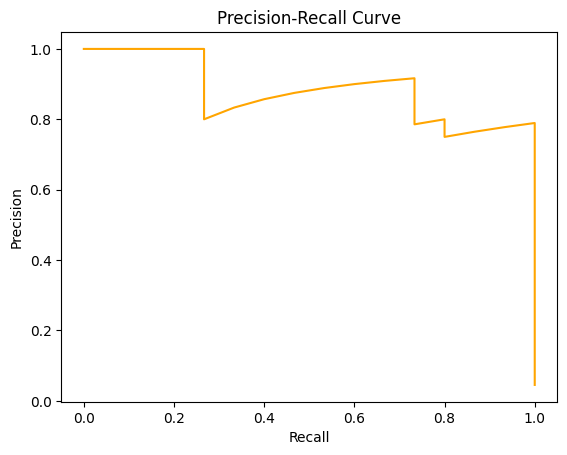

In [106]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(df['Real'], df['Prob'])

_, ax = plt.subplots()
ax.plot(recall, precision, color='orange')

ax.set_title('Precision-Recall Curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.show()

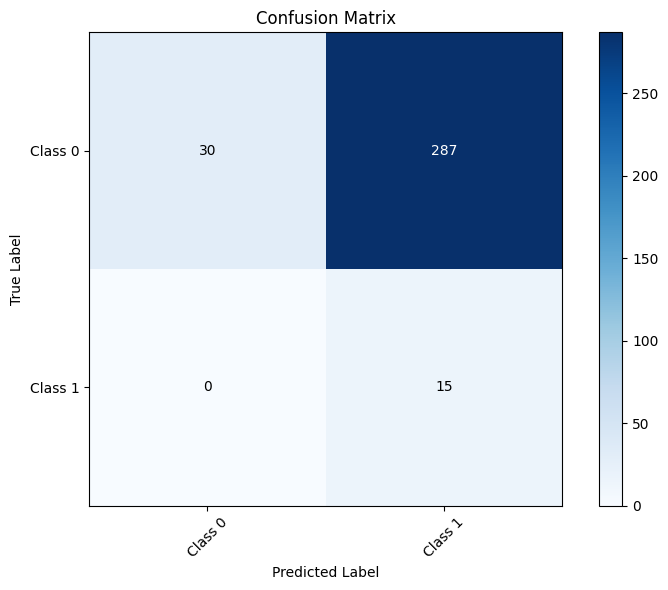

In [107]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you already have the confusion matrix 'cm'
cm = confusion_matrix(df['Real'], df['Pred'])

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    plt.show()

# Define class labels (if applicable)
class_labels = ['Class 0', 'Class 1']

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=class_labels)

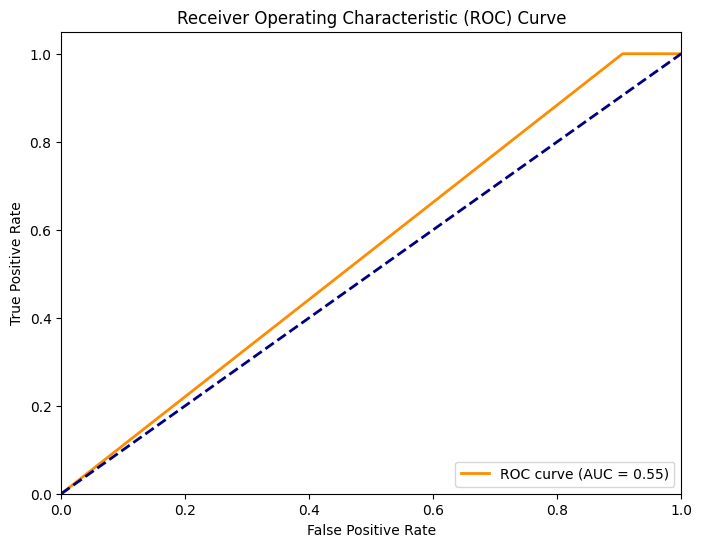

In [108]:
def plot_roc_curve(predictions_df):
    # Extract the 'Real', 'Pred', and 'Prob' columns
    ground_truth_values = predictions_df['Real'].tolist()
    predictions = predictions_df['Pred'].tolist()

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(ground_truth_values, predictions)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = roc_auc_score(ground_truth_values, predictions)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage:
plot_roc_curve(df)

In [109]:
was_in_train = examples[labels == 1]
was_in_test = examples_test[labels_test == 1]

In [110]:
was_in_train = [(int(a), int(b)) for a,b in was_in_train]
was_in_test = [(int(a), int(b)) for a,b in was_in_test]

In [111]:
def was_in_test_function(row, list):
    src, dest = row['Connection']

    if [src, dest] in list or (dest, src) in list:
        return 1
    else:
        return 0

df['IncludedInTrain'] = df.apply(lambda x: was_in_test_function(x, was_in_train), axis=1)
df['IncludedInTest'] = df.apply(lambda x: was_in_test_function(x, was_in_test), axis=1)

In [112]:
t = df[df['IncludedInTrain'] == 1]
train_acc = calculate_accuracy(t['Real'], t['Pred'])


t = df[df['IncludedInTest'] == 1]
test_acc = calculate_accuracy(t['Real'], t['Pred'])

t = df[~((df['IncludedInTrain'] == 1) | (df['IncludedInTest'] == 1))]
not_in_any_acc = calculate_accuracy(t['Real'], t['Pred'])

accuracy = calculate_accuracy(df['Real'], df['Pred'])

print(f'Train Accuracy: {train_acc:.2%}')
print(f'Test Accuracy: {test_acc:.2%}')
print(f'Not in any Accuracy: {not_in_any_acc:.2%}')
print(f'Test Accuracy: {accuracy:.2%}')

Train Accuracy: nan%
Test Accuracy: nan%
Not in any Accuracy: 13.55%
Test Accuracy: 13.55%


c:\users\geako\dataspellprojects\friend_venv\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\users\geako\dataspellprojects\friend_venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\users\geako\dataspellprojects\friend_venv\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\users\geako\dataspellprojects\friend_venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [113]:
df.sort_values('Prob', ascending =False)

,Connection,Real,Pred,Prob,IncludedInTrain,IncludedInTest
176,"(2, 144)",1,1,0.532755,0,0
161,"(2, 116)",1,1,0.532706,0,0
133,"(2, 208)",1,1,0.532696,0,0
165,"(2, 167)",1,1,0.532690,0,0
35,"(2, 19)",0,1,0.532550,0,0
...,...,...,...,...,...,...
193,"(2, 147)",0,0,0.420860,0,0
299,"(2, 305)",0,0,0.416630,0,0
302,"(2, 321)",0,0,0.414845,0,0
298,"(2, 262)",0,0,0.412169,0,0


In [114]:
result = df[(df['Real'] == 0) & (df['Pred'] == 1)].sort_values('Prob', ascending = False).head(10)

In [115]:
result['recommended_friend'] = result['Connection'].apply(lambda x: x[1])

In [116]:
new_recomendations = list(result['Connection'].values)

In [117]:
def visualize_graph(graph, recommended_edges=None):
    # Create a NetworkX graph from your 'graph' adjacency matrix
    G = nx.Graph(graph)

    # Create positions for the nodes using a layout algorithm (e.g., spring_layout)
    pos = nx.spring_layout(G)

    # Create edges and nodes
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_trace = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=10,
        )
    )

    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])

    for node in G.nodes():
        x, y = pos[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])

    # Add recommended edges in green color
    if recommended_edges:
        recommended_x = []
        recommended_y = []
        recommended_text = []

        for edge in recommended_edges:
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            recommended_x += [x0, x1, None]
            recommended_y += [y0, y1, None]
            recommended_text.append(f"Edge: {edge}, Color: Green")

        edge_trace_recommended = go.Scatter(
            x=recommended_x,
            y=recommended_y,
            text=recommended_text,
            line=dict(width=2, color='green'),
            hoverinfo='text',
            mode='lines'
        )

        fig = go.Figure(data=[edge_trace, node_trace, edge_trace_recommended],
                        layout=go.Layout(
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=0, l=0, r=0, t=0)
                        )
                        )

    else:
        fig = go.Figure(data=[edge_trace, node_trace],
                        layout=go.Layout(
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=0, l=0, r=0, t=0)
                        )
                        )

    fig.show()


G_nx = G.to_networkx()

# Example usage:
# visualize_graph(G_nx, recommended_edges=new_recomendations)

## Recommend For All

In [118]:
possible_connections = []
for user in G.nodes():
    for node in G.nodes():
        if node != user:
            possible_connections.append((user, node))

In [ ]:
existing_connections = {}
for (start, end ) in possible_connections:
    if (start, end) in G.edges() or (end, start) in G.edges():
        existing_connections[(start, end)] = 1
    else:
        existing_connections[(start, end)] = 0

In [ ]:
best_binary_operator = best_result['binary_operator']
model = best_result['classifier']

emb_distance = [best_binary_operator(embedding_train(src), embedding_train(dst)) for src, dst in possible_connections]

In [ ]:
preds = model.predict(emb_distance)
pred_prob = model.predict_proba(emb_distance)

# Create a DataFrame from the existing_connections dictionary
df = pd.DataFrame(list(existing_connections.items()), columns=['Connection', 'Real'])
df['Pred'] = preds
df['Prob'] = pred_prob[:, 1]

In [ ]:
accuracy = calculate_accuracy(df['Real'], df['Pred'])

In [ ]:
accuracy

In [ ]:
df['Prob'].hist()

In [ ]:
df['Real'].value_counts()

In [ ]:
df['Pred'].value_counts()

In [ ]:
plot_roc_curve(df)

In [ ]:
# Writing the object to a file
with open('best_result.pkl', 'wb') as file:
    pickle.dump(best_result, file)

with open('used_params.pkl', 'wb') as file:
    pickle.dump(used_params, file)

In [ ]:
best_result

In [ ]:
ids = ['0', '107', '348', '414', '686', '698']

def get_path(id):
    path = f'facebook/{id}.edges' # 0.edges
    return path

for id in ids:
    edge_path = get_path(id)
    G = nx.read_edgelist(edge_path, nodetype=int, create_using=nx.Graph())
    G = sg.StellarGraph.from_networkx(G)
    print(id)
    print(f'Nodes: {len(G.nodes())}')
    print(f'Edges: {len(G.edges())}')
    print('+++++++++++++++++++++')

In [ ]:
# 333 * 332 / 2

In [ ]:
# Beolvasom a fájlt

## Gráf Beolvasása

In [ ]:
def is_directed_graph(graph):

    adjacency_matrix = nx.to_numpy_array(graph)
    A = np.array(adjacency_matrix)

    # Csekkolom, hogy szimmetrikus-e, elméletileg annak kell lennie
    is_symmetric = np.allclose(A, A.T)

    if is_symmetric:
        print("The matrix is symmetric, not directed")
    else:
        print("The matrix is not symmetric.")

def print_graph_info(G):
    text = G.info()
    print(text)

In [ ]:
G = nx.read_edgelist(edge_path, nodetype=int, create_using=nx.Graph())
for edge in G.edges():
    G[edge[0]][edge[1]]['weight'] = 1

# is_directed_graph(G)
# Castolás StellarGraph-ra, ment ebben találtam hasznos függvényeket
G = sg.StellarGraph.from_networkx(G)

In [ ]:
print_graph_info(G)

In [ ]:
edge_splitter_test = EdgeSplitter(G)

In [ ]:
# Itt az edge_splitter tesztből vesz éleket, ezeket az examples_test,
# Majd vesz negatív éleket is, ezt szintén hozzárakja az examples_test-hez concatolva,
# a labels test az, hogy ez az él létezik-e vagy sem
# a graph test a gráf a maradék éllel
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(p=0.1, method="global")

In [ ]:
print_graph_info(graph_test)

In [ ]:
edge_splitter_train = EdgeSplitter(g=graph_test, g_master=G)
graph_train, examples, labels = edge_splitter_train.train_test_split(p=0.1, method="global")



(examples_train, examples_model_selection, labels_train, labels_model_selection,)\
                                        = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

In [ ]:
print_graph_info(graph_train)

In [ ]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

In [ ]:
used_params = {
    'p': 1.0,
    'q': 0.6,
    'dimensions': 128,
    'num_walks': 60,
    'walk_length': 60,
    'window_size': 11,
    'num_iter': 5
}

In [ ]:
# p = 1.0
# q = 1.0
# dimensions = 128
# num_walks = 60
# walk_length = 60
# window_size = 16
# num_iter = 5
workers = multiprocessing.cpu_count()

In [ ]:
def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=used_params['num_walks'], length=used_params['walk_length'], p=used_params['p'], q=used_params['q'])
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        vector_size=used_params['dimensions'],
        window=used_params['window_size'],
        min_count=0,
        sg=1,
        workers=workers,
        epochs=used_params['num_iter'],
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [ ]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")

In [ ]:
# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]

# 2. training classifier
def train_link_prediction_model(
        link_examples, link_labels, get_embedding, binary_operator
):
    # Ezt akár lehet módosítani is más algoritmussal
    clf = link_prediction_classifier()

    # Itt távolságot számol a start és end pont embeddingje között
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    # Majd arra fitteli a modelt
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=4000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
        clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

In [ ]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }

binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [ ]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

In [ ]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

In [ ]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

In [ ]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)

## Inference

In [ ]:
print(G.info())

In [ ]:
embedding_all = node2vec_embedding(G, "Test Graph")

In [ ]:
final_model = best_result['classifier']
final_operator = best_result['binary_operator']

In [ ]:
nodes = list(G.nodes())

In [ ]:
n = len(G.nodes())

A = np.zeros((n, n))

In [ ]:
A = {}

In [ ]:
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            first_embedding = embedding_all(node1)
            second_embedding = embedding_all(node2)

            distance_vector = final_operator(first_embedding, second_embedding)

            prob = final_model.predict_proba([distance_vector])

            A[(node1, node2)] = prob[0][0]

In [ ]:
# Create a histogram
plt.hist(list(A.values()), bins=20)  # You can adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()

In [ ]:
len(A.values())

In [ ]:
user = 2 #322

possible_connections = []

for node in G.nodes():
    if node != user:
        possible_connections.append((user, node))

In [ ]:
len(possible_connections)

In [ ]:
existing_connections = {}
for (start, end ) in possible_connections:
    if (start, end) in G.edges() or (end, start) in G.edges():
        existing_connections[(start, end)] = 1
    else:
        existing_connections[(start, end)] = 0

In [ ]:
best_binary_operator = best_result['binary_operator']
model = best_result['classifier']

full_graph = node2vec_embedding(G, "Full graph embedding")

emb_distance = [best_binary_operator(embedding_train(src), embedding_train(dst)) for src, dst in possible_connections]

In [ ]:
preds = model.predict(emb_distance)
pred_prob = model.predict_proba(emb_distance)

In [ ]:
# Create a DataFrame from the existing_connections dictionary
df = pd.DataFrame(list(existing_connections.items()), columns=['Connection', 'Real'])
df['Pred'] = preds
df['Prob'] = pred_prob[:, 1]

In [ ]:
def calculate_accuracy(real, pred):
    accuracy = accuracy_score(real, pred)
    return accuracy

calculate_accuracy(df['Real'], df['Pred']);

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(df['Real'], df['Prob'])

_, ax = plt.subplots()
ax.plot(recall, precision, color='orange')

ax.set_title('Precision-Recall Curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you already have the confusion matrix 'cm'
cm = confusion_matrix(df['Real'], df['Pred'])

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    plt.show()

# Define class labels (if applicable)
class_labels = ['Class 0', 'Class 1']

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=class_labels)

In [ ]:
def plot_roc_curve(predictions_df):
    # Extract the 'Real', 'Pred', and 'Prob' columns
    ground_truth_values = predictions_df['Real'].tolist()
    predictions = predictions_df['Pred'].tolist()

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(ground_truth_values, predictions)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = roc_auc_score(ground_truth_values, predictions)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage:
plot_roc_curve(df)

In [ ]:
was_in_train = examples[labels == 1]
was_in_test = examples_test[labels_test == 1]

In [ ]:
was_in_train = [(int(a), int(b)) for a,b in was_in_train]
was_in_test = [(int(a), int(b)) for a,b in was_in_test]

In [ ]:
def was_in_test_function(row, list):
    src, dest = row['Connection']

    if [src, dest] in list or (dest, src) in list:
        return 1
    else:
        return 0

df['IncludedInTrain'] = df.apply(lambda x: was_in_test_function(x, was_in_train), axis=1)
df['IncludedInTest'] = df.apply(lambda x: was_in_test_function(x, was_in_test), axis=1)

In [ ]:
t = df[df['IncludedInTrain'] == 1]
train_acc = calculate_accuracy(t['Real'], t['Pred'])


t = df[df['IncludedInTest'] == 1]
test_acc = calculate_accuracy(t['Real'], t['Pred'])

t = df[~((df['IncludedInTrain'] == 1) | (df['IncludedInTest'] == 1))]
not_in_any_acc = calculate_accuracy(t['Real'], t['Pred'])

accuracy = calculate_accuracy(df['Real'], df['Pred'])

print(f'Train Accuracy: {train_acc:.2%}')
print(f'Test Accuracy: {test_acc:.2%}')
print(f'Not in any Accuracy: {not_in_any_acc:.2%}')
print(f'Test Accuracy: {accuracy:.2%}')

In [ ]:
df.sort_values('Prob', ascending =False)

In [ ]:
result = df[(df['Real'] == 0) & (df['Pred'] == 1)].sort_values('Prob', ascending = False).head(10)

In [ ]:
result['recommended_friend'] = result['Connection'].apply(lambda x: x[1])

In [ ]:
new_recomendations = list(result['Connection'].values)

In [ ]:
def visualize_graph(graph, recommended_edges=None):
    # Create a NetworkX graph from your 'graph' adjacency matrix
    G = nx.Graph(graph)

    # Create positions for the nodes using a layout algorithm (e.g., spring_layout)
    pos = nx.spring_layout(G)

    # Create edges and nodes
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_trace = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=10,
        )
    )

    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])

    for node in G.nodes():
        x, y = pos[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])

    # Add recommended edges in green color
    if recommended_edges:
        recommended_x = []
        recommended_y = []
        recommended_text = []

        for edge in recommended_edges:
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            recommended_x += [x0, x1, None]
            recommended_y += [y0, y1, None]
            recommended_text.append(f"Edge: {edge}, Color: Green")

        edge_trace_recommended = go.Scatter(
            x=recommended_x,
            y=recommended_y,
            text=recommended_text,
            line=dict(width=2, color='green'),
            hoverinfo='text',
            mode='lines'
        )

        fig = go.Figure(data=[edge_trace, node_trace, edge_trace_recommended],
                        layout=go.Layout(
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=0, l=0, r=0, t=0)
                        )
                        )

    else:
        fig = go.Figure(data=[edge_trace, node_trace],
                        layout=go.Layout(
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=0, l=0, r=0, t=0)
                        )
                        )

    fig.show()


G_nx = G.to_networkx()

# Example usage:
# visualize_graph(G_nx, recommended_edges=new_recomendations)

## Recommend For All

In [ ]:
possible_connections = []
for user in G.nodes():
    for node in G.nodes():
        if node != user:
            possible_connections.append((user, node))

In [ ]:
existing_connections = {}
for (start, end ) in possible_connections:
    if (start, end) in G.edges() or (end, start) in G.edges():
        existing_connections[(start, end)] = 1
    else:
        existing_connections[(start, end)] = 0

In [ ]:
best_binary_operator = best_result['binary_operator']
model = best_result['classifier']

emb_distance = [best_binary_operator(embedding_train(src), embedding_train(dst)) for src, dst in possible_connections]

In [ ]:
preds = model.predict(emb_distance)
pred_prob = model.predict_proba(emb_distance)

# Create a DataFrame from the existing_connections dictionary
df = pd.DataFrame(list(existing_connections.items()), columns=['Connection', 'Real'])
df['Pred'] = preds
df['Prob'] = pred_prob[:, 1]

In [ ]:
accuracy = calculate_accuracy(df['Real'], df['Pred'])

In [ ]:
accuracy

In [ ]:
df['Prob'].hist()

In [ ]:
df['Real'].value_counts()

In [ ]:
df['Pred'].value_counts()

In [ ]:
plot_roc_curve(df)

In [ ]:
# Writing the object to a file
with open('best_result.pkl', 'wb') as file:
    pickle.dump(best_result, file)

with open('used_params.pkl', 'wb') as file:
    pickle.dump(used_params, file)

In [ ]:
best_result

In [ ]:
ids = ['0', '107', '348', '414', '686', '698']

def get_path(id):
    path = f'facebook/{id}.edges' # 0.edges
    return path

for id in ids:
    edge_path = get_path(id)
    G = nx.read_edgelist(edge_path, nodetype=int, create_using=nx.Graph())
    G = sg.StellarGraph.from_networkx(G)
    print(id)
    print(f'Nodes: {len(G.nodes())}')
    print(f'Edges: {len(G.edges())}')
    print('+++++++++++++++++++++')

In [ ]:
# 333 * 332 / 2